# Multiclass Classification with Penalized Linear Regression - Classifying Crime Scene Glass Samples

In [1]:
from math import sqrt, fabs, exp
import matplotlib.pyplot as plt
from sklearn.linear_model import enet_path
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import seaborn as sns

sns.set()

In [2]:
# arrange data into list for labels and list of lists for attributes
x_list = []
data_path = './data/glass.data'

with open(data_path) as data:
    
    for line in data:
        # split on comma
        row = line.strip().split(',')
        x_list.append(row)

names = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']

# Separate attributes and labels
x_num = []
labels = []

for row in x_list:
    labels.append(row.pop())
    l = len(row)
    
    # eliminate ID
    attr_row = [float(row[i]) for i in range(1, l)]
    x_num.append(attr_row)
    
# number of rows and columns in x matrix
n_row = len(x_num)
n_col = len(x_num[1])

# create one versus all label vectors
# get distinct glass tpyes and assign index to each
y_one_v_all = []
label_set = set(labels)
label_list = list(label_set)
label_list.sort()
n_labels = len(label_list)

for i in range(n_row):
    y_row = [0.0] * n_labels
    index = label_list.index(labels[i])
    y_row[index] = 1.0
    y_one_v_all.append(y_row)

In [3]:
# calculate means and variances
x_means = []
x_sd = []

for i in range(n_col):
    col = [x_num[j][i] for j in range(n_row)]
    mean = sum(col)/n_row
    x_means.append(mean)
    
    col_diff = [(x_num[j][i] - mean) for j in range(n_row)]
    sum_sq = sum([col_diff[i] ** 2 for i in range(n_row)])
    std_dev = sqrt(sum_sq/n_row)
    x_sd.append(std_dev)
    
# use calculated mean and standard deviation to normalize x_num
x_normalized = []

for i in range(n_row):
    row_normalized = [(x_num[i][j] - x_means[j])/x_sd[j] for j in range(n_col)]
    x_normalized.append(row_normalized)

# normalize y to center
y_means = []
y_sd = []

for i in range(n_labels):
    col = [y_one_v_all[j][i] for j in range(n_row)]
    mean = sum(col)/n_row
    y_means.append(mean)
    
    col_diff = [(y_one_v_all[j][i] - mean) for j in range(n_row)]
    sum_sq = sum([col_diff[i] ** 2 for i in range(n_row)])
    std_dev = sqrt(sum_sq/n_row)
    y_sd.append(std_dev)
    
y_normalized = []

for i in range(n_row):
    row_normalized = [(y_one_v_all[i][j] - y_means[j])/y_sd[j] for j in range(n_labels)]
    y_normalized.append(row_normalized)

/home/michael/.virtualenvs/ml_in_py-5Jtq3_sG/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


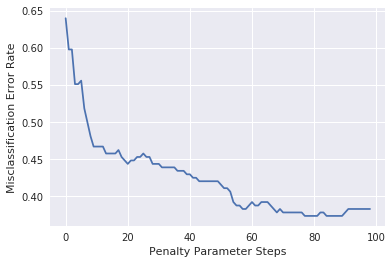

In [4]:
# number of cross-validation folds
n_x_val = 10
n_alphas = 100
misclass = [0.0] * n_alphas

for i_x_val in range(n_x_val):
    # Define test and training index sets
    idx_test = [a for a in range(n_row) if a % n_x_val == i_x_val % n_x_val]
    idx_train = [a for a in range(n_row) if a % n_x_val != i_x_val % n_x_val]
    
    # Define test and training attribute and label sets
    x_train = np.array([x_normalized[r] for r in idx_train])
    x_test = np.array([x_normalized[r] for r in idx_test])
        
    y_train = np.array([y_normalized[r] for r in idx_train])
    y_test = np.array([y_normalized[r] for r in idx_test])
    labels_test = [labels[r] for r in idx_test]
    
    # build model for each column in y_train
    models = []
    len_train = len(y_train)
    len_test = n_row - len_train
    
    for i_model in range(n_labels):
        y_temp = np.array([y_train[j][i_model] for j in range(len_train)])
        models.append(enet_path(x_train, y_temp, l1_ratio=1.0, fit_intercept=False, eps=0.5e-3, 
                                n_alphas=n_alphas, return_models=False))
        
    for i_step in range(1, n_alphas):
        # Assemble the predictions for all the models, find largest prediction and calc error
        all_predictions = []
        
        for i_model in range(n_labels):
            _, coefs, _ = models[i_model]
            pred_temp = list(np.dot(x_test, coefs[:, i_step]))
            
            # unnormalize the prediction for comparsion
            pred_unnorm = [(pred_temp[j] * y_sd[i_model] + y_means[i_model]) for j in range(len(pred_temp))]
            all_predictions.append(pred_unnorm)
            
        predictions = []
        
        for i in range(len_test):
            list_of_predictions = [all_predictions[j][i] for j in range(n_labels)]
            idx_max = list_of_predictions.index(max(list_of_predictions))
            
            if label_list[idx_max] != labels_test[i]:
                misclass[i_step] += 1.0
                
misclass_plot = [misclass[i]/n_row for i in range(1, n_alphas)]
plt.plot(misclass_plot)

plt.xlabel('Penalty Parameter Steps')
plt.ylabel('Misclassification Error Rate')
plt.show()
        